In [ ]:
import nibabel as nib
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from keras.layers import Conv1D,Input,LSTM,TimeDistributed,concatenate,Dense
from keras.models import Model
from keras.optimizers.legacy import Adam
import keras.backend as T
import sys
import scipy.io as si
import numpy
from keras.constraints import non_neg,Constraint
dense_size = 128
import h5py
from scipy.stats.mstats import zscore
from sklearn.model_selection import train_test_split
from scipy.io import savemat
import random
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
random.seed(42)

In [ ]:
## import dataset for simple simulations
# gt_list = numpy.loadtxt('drive/MyDrive/dataset/simulations/gt_list_z+s_std=1.csv',
#                  delimiter=",", dtype=float)
# obs_list = numpy.loadtxt('drive/MyDrive/dataset/simulations/obs_list_z+s_std=1.csv',
#                  delimiter=",", dtype=float)
# noi_list = numpy.loadtxt('drive/MyDrive/dataset/simulations/noi_list_z+s_std=1.csv',
#                  delimiter=",", dtype=float)

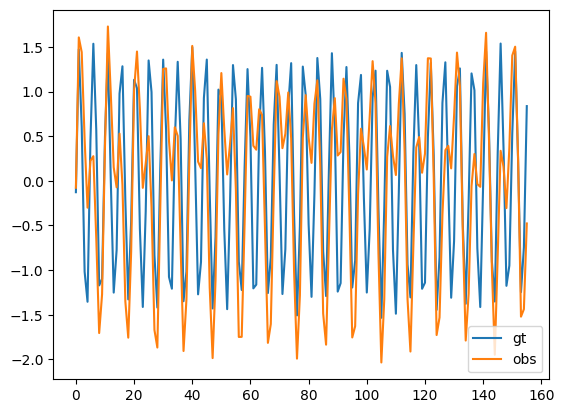

In [ ]:
# visuialize the dataset
plt.plot(gt_list[500], label = 'gt')
plt.plot(obs_list[500], label = 'obs')
#plt.plot(noi_list[50], label = 'noi')
plt.legend()

In [ ]:
# import dataset for realistic simulations
obs_list = numpy.loadtxt('drive/MyDrive/dataset/obs_list.csv',dtype=float,delimiter=',',usecols=range(156))
gt_list = numpy.loadtxt('drive/MyDrive/dataset/gt_list.csv',dtype=float,delimiter=',',usecols=range(156))
noi_list = numpy.loadtxt('drive/MyDrive/dataset/noi_list.csv',dtype=float,delimiter=',',usecols=range(156))

### DeNN model structure and training

In [ ]:
# DeNN model structure
def denoise_model_general(tdim,layers_type=["tden","tdis","tdis","conv","conv","conv"],layers_size=[128,32,16,8,4,1]):
    """
        denoise_model_general(tdim,layers_type,layers_size):
            Time-dependent fully-connected layers are required to be before all the other layers. Multiple time-dependent layers can be specified.
            layers_type: list, with element value as "tden","tdis","conv",e.g. ["tden","tdis","tdis","conv","conv","conv"]
            layers_size: list, e.g. [128,32,16,8,4,1]
    """
    input_fMRI = [Input(shape=(1,1)) for i in range(tdim)]
    input_dwt = [Input(shape=(1,1)) for i in range(tdim)]
    output_fMRI = input_fMRI
    output_dwt = input_dwt
    if len(layers_type)!=len(layers_size):
        print("error: the size for layers_type and layers_size do not match")
        return 0
    elif layers_size[-1]!=1:
        print("error: the size for the last layer has to be 1")
        return 0
    else:
        for layer_ind,layer_name in enumerate(layers_type):
            if layer_name=="tden":
                layer = [Dense(layers_size[layer_ind],activation='linear') for i in range(tdim)]
                output_fMRI = [layer[i](output_fMRI[i]) for i in range(tdim)]
                output_dwt = [layer[i](output_dwt[i]) for i in range(tdim)]
                if layer_ind==len(layers_type)-1 or layers_type[layer_ind+1]!="tden":
                    output_fMRI = concatenate(output_fMRI,axis=1)
                    output_dwt = concatenate(output_dwt,axis=1)
            elif layer_name=="conv":
                if layer_ind==0:
                    output_fMRI = concatenate(output_fMRI,axis=1)
                    output_dwt = concatenate(output_dwt,axis=1)
                layer = Conv1D(layers_size[layer_ind],5,padding='same')
                output_fMRI = layer(output_fMRI)
                output_dwt = layer(output_dwt)
            elif layer_name == "tdis":
                if layer_ind==0:
                    output_fMRI = concatenate(output_fMRI,axis=1)
                    output_dwt = concatenate(output_dwt,axis=1)
                layer = TimeDistributed(Dense(layers_size[layer_ind],activation='linear'))
                output_fMRI = layer(output_fMRI)
                output_dwt = layer(output_dwt)
        merged_data = concatenate([output_fMRI,output_dwt],axis=-1)
        model = Model(inputs = input_fMRI+input_dwt,outputs = merged_data)
        return model

In [ ]:
def denoise_loss(y_true,y_pred):
    output_fMRI = y_pred[:,:,0]
#    output_dwt = y_true[:,:,0]
    output_dwt  = y_pred[:,:,1]
    tdim = output_fMRI.shape[1]
    output_fMRI = output_fMRI - T.mean(output_fMRI,axis=-1,keepdims=True)
    output_dwt  = output_dwt - T.mean(output_dwt,axis = -1,keepdims=True)
    output_fMRI = output_fMRI/T.std(output_fMRI,axis=-1,keepdims=True)
    output_dwt  = output_dwt/T.std(output_dwt,axis=-1,keepdims=True)
    corr_mat = T.dot(output_fMRI,T.transpose(output_fMRI))/tdim
    corr_fMRI = T.mean(T.abs(corr_mat))/2
    corr_mat = T.dot(output_dwt,T.transpose(output_dwt))/tdim
    corr_dwt = T.mean(T.abs(corr_mat))/2
    corr_mat = T.dot(output_fMRI,T.transpose(output_dwt))/tdim
    corr_fMRIdwt = T.mean(T.abs(corr_mat))
    return corr_fMRIdwt #corr_dwt - corr_fMRI

In [ ]:
obs_list = numpy.reshape(obs_list,obs_list.shape+(1,))
gt_list = numpy.reshape(gt_list,gt_list.shape+(1,))
noi_list = numpy.reshape(noi_list,noi_list.shape+(1,))

In [ ]:
obs_train, obs_test, gt_train, gt_test = train_test_split(obs_list, gt_list, test_size=0.15)

In [ ]:
nvoxel_train = obs_train.shape[0]
trainind_c23 = numpy.random.permutation(noi_list.shape[0])[:nvoxel_train]
tdim = obs_train.shape[1]

In [ ]:
model = denoise_model_general(tdim,layers_type=["tden","tdis","tdis","conv","conv","conv"],layers_size=[128,32,16,8,4,1])
opt = Adam(lr=0.05,beta_1=0.9, beta_2 = 0.999, decay = 0.05)
model.compile(optimizer=opt,loss=denoise_loss)
epochs = 50
train_c1 = obs_train
train_c23= noi_list[trainind_c23,:,:]
y_true = numpy.ones((nvoxel_train,tdim,2))#fMRIdata_c23_strict[trainind_c23,:,:]#
history = model.fit([train_c1[:,[i],:] for i in range(tdim)]+
                    [train_c23[:,[i],:] for i in range(tdim)],
                    y=y_true,batch_size = 500,validation_split=0.15/0.85,epochs = epochs)
fMRIdata_q_output = model.predict([obs_test[:,[i],:] for i in range(tdim)]+
                                    [obs_test[:,[i],:] for i in range(tdim)]
                                    ,batch_size=500)
loss = history.history['loss']
valloss = history.history['val_loss']

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
22/22 [==============================] - 38s 629ms/step - loss: 0.1483 - val_loss: 0.1157
Epoch 2/50
22/22 [==============================] - 3s 144ms/step - loss: 0.1115 - val_loss: 0.1083
Epoch 3/50
22/22 [==============================] - 3s 134ms/step - loss: 0.1063 - val_loss: 0.1045
Epoch 4/50
22/22 [==============================] - 3s 142ms/step - loss: 0.1027 - val_loss: 0.1014
Epoch 5/50
22/22 [==============================] - 3s 135ms/step - loss: 0.0996 - val_loss: 0.0984
Epoch 6/50
22/22 [==============================] - 3s 148ms/step - loss: 0.0969 - val_loss: 0.0961
Epoch 7/50
22/22 [==============================] - 3s 135ms/step - loss: 0.0949 - val_loss: 0.0945
Epoch 8/50
22/22 [==============================] - 3s 150ms/step - loss: 0.0934 - val_loss: 0.0932
Epoch 9/50
22/22 [==============================] - 3s 139ms/step - loss: 0.0923 - val_loss: 0.0922
Epoch 10/50
22/22 [==============================] - 3s 138ms/step - loss: 0.0913 - val_loss: 0.091

In [ ]:
savemat('drive/MyDrive/dataset/model_z+s_std=1.mat',{'fMRIdata_q':fMRIdata_q_output[:,:,0],
                            'loss':loss,'valloss':valloss})

In [ ]:
fMRIdata_q_output.shape

(2322, 156, 2)

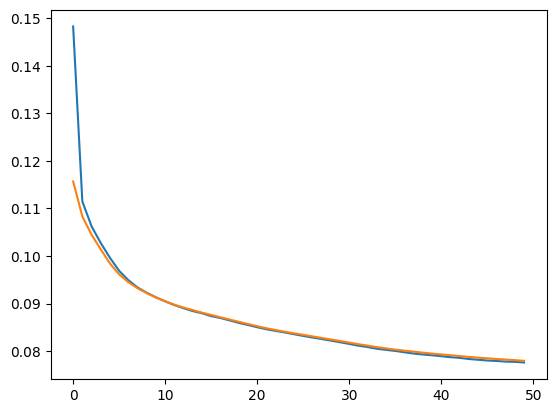

In [ ]:
# plot loss and validation loss
plt.plot(loss)
plt.plot(valloss)

In [ ]:
def r_squared_list(x,y):
  # calculate the R-squared between each pair of sequences in two lists of sequences
  x_mean = numpy.repeat(numpy.reshape(x.mean(axis=1),(x.shape[0],1)),x.shape[1],axis=1)
  y_mean = numpy.repeat(numpy.reshape(y.mean(axis=1),(y.shape[0],1)),y.shape[1],axis=1)
  cov = (x-x_mean)*(y-y_mean)
  r_row = cov.sum(axis=1)/(x.std(axis=1)*y.std(axis=1)*x.shape[1])
  return numpy.square(r_row)

In [ ]:
test_r_squared_list = r_squared_list(fMRIdata_q_output[:,:,0],numpy.squeeze(gt_test))
test_mean = test_r_squared_list.mean()
test_percentile= (numpy.percentile(test_r_squared_list,5), numpy.percentile(test_r_squared_list,95))

In [ ]:
print(test_mean)
print(test_percentile)

0.006093546347596054
(2.5048556568856952e-05, 0.023431759425393356)


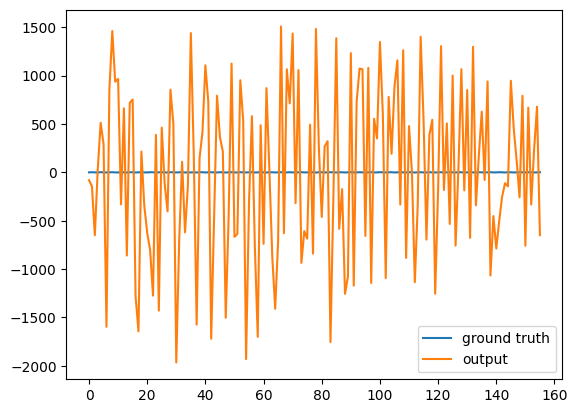

In [ ]:
#plt.plot(obs_test[0])
plt.plot(gt_test[0],label="ground truth")
plt.plot(fMRIdata_q_output[0,:,0],label="output")
plt.legend()

### comparison to DeepCor


In [ ]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

In [ ]:
# realistic model structure
import torch
from torch import nn
from torch.nn import functional as F

class cVAE(nn.Module):


    def __init__(self,in_channels: int,latent_dim: int,hidden_dims: List = None) -> None:
        super(cVAE, self).__init__()

        self.latent_dim = latent_dim
        self.in_channels = in_channels

        modules_z = []
        if hidden_dims is None:
            hidden_dims = [64, 128, 256, 256]

        # Build Encoder
        for h_dim in hidden_dims:
            modules_z.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_z = nn.Sequential(*modules_z)
        self.fc_mu_z = nn.Linear(hidden_dims[-1]*10, latent_dim)
        self.fc_var_z = nn.Linear(hidden_dims[-1]*10, latent_dim)

        modules_s = []
        in_channels = self.in_channels
        for h_dim in hidden_dims:
            modules_s.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_s = nn.Sequential(*modules_s)
        self.fc_mu_s = nn.Linear(hidden_dims[-1]*10, latent_dim)
        self.fc_var_s = nn.Linear(hidden_dims[-1]*10, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * 10)

        hidden_dims.reverse()


        for i in range(len(hidden_dims) - 1):
            if i//2==0:
                modules.append(
                    nn.Sequential(
                        nn.ConvTranspose1d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                        nn.BatchNorm1d(hidden_dims[i + 1]),
                        nn.LeakyReLU())
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.ConvTranspose1d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=0),
                        nn.BatchNorm1d(hidden_dims[i + 1]),
                        nn.LeakyReLU())
                )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=2,
                                               output_padding=1),
                            nn.BatchNorm1d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv1d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1))
           #out_channels

    def encode_z(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        """
        result = self.encoder_z(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_z(result)
        log_var = self.fc_var_z(result)

        return [mu, log_var]

    def encode_s(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        """
        result = self.encoder_s(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_s(result)
        log_var = self.fc_var_s(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the sequence space.
        """
        result = self.decoder_input(z)
        result = result.view(-1,256,10)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward_tg(self, input: Tensor) -> List[Tensor]:
        """
        Forward the input to both encoder s and z and concatenate them
        """
        tg_mu_z, tg_log_var_z = self.encode_z(input)
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        output = self.decode(torch.cat((tg_z, tg_s),1))
        return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

    def forward_bg(self, input: Tensor) -> List[Tensor]:
        """
        Forward the input to both encoder s only and make another half of latent space 0s
        """
        bg_mu_s, bg_log_var_s = self.encode_s(input)
        bg_s = self.reparameterize(bg_mu_s, bg_log_var_s)
        zeros = torch.zeros_like(bg_s)
        output = self.decode(torch.cat((zeros, bg_s),1))
        return  [output, input, bg_mu_s, bg_log_var_s]

    def forward_fg(self, input: Tensor) -> List[Tensor]:
        """
        Forward the input to both encoder z only and make another half of latent space 0s
        """
        fg_mu_z, fg_log_var_z = self.encode_z(input)
        tg_z = self.reparameterize(fg_mu_z, fg_log_var_z)
        zeros = torch.zeros_like(tg_z)
        output = self.decode(torch.cat((tg_z, zeros),1))
        return  [output, input, fg_mu_z, fg_log_var_z]

    def loss_function(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        """
        beta = 0.00001 # ratio of kl loss compared to reconstruction loss
        gamma = 1

        recons_tg = args[0]
        input_tg = args[1]
        tg_mu_z = args[2]
        tg_log_var_z = args[3]
        tg_mu_s = args[4]
        tg_log_var_s = args[5]
        tg_z = args[6]
        tg_s = args[7]
        recons_bg = args[8]
        input_bg = args[9]
        bg_mu_s = args[10]
        bg_log_var_s = args[11]

        recons_loss = F.mse_loss(recons_tg, input_tg)
        recons_loss += F.mse_loss(recons_bg, input_bg)


        kld_loss = 1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp()
        kld_loss += 1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp()
        kld_loss += 1 + bg_log_var_s - bg_mu_s ** 2 - bg_log_var_s.exp()
        kld_loss = torch.mean(-0.5 * torch.sum(kld_loss, dim = 1), dim = 0)

        loss = torch.mean(recons_loss + beta*kld_loss)
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD': kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        sequence space map.
        """
        z = torch.randn(num_samples,
                        self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        """
        return self.forward_fg(x)[0]

In [ ]:
## simple model structure
# import torch
# from torch import nn
# from torch.nn import functional as F

# class cVAE(nn.Module):


#     def __init__(self,in_channels: int,latent_dim: int,hidden_dims: List = None) -> None:
#         super(cVAE, self).__init__()

#         self.latent_dim = latent_dim
#         self.in_channels = in_channels
#         self.hidden_dims = hidden_dims

#         modules_z = []
#         if hidden_dims is None:
#             hidden_dims = [32, 64, 128, 128]

#         # Build Encoders
#         for h_dim in hidden_dims:
#             modules_z.append(
#                 nn.Sequential(
#                     nn.Conv1d(in_channels, out_channels=h_dim,
#                               kernel_size= 3, stride= 2, padding  = 1),
#                     nn.BatchNorm1d(h_dim),
#                     nn.LeakyReLU())
#             )
#             in_channels = h_dim

#         self.encoder_z = nn.Sequential(*modules_z)
#         self.fc_mu_z = nn.Linear(hidden_dims[-1]*10, latent_dim)
#         self.fc_var_z = nn.Linear(hidden_dims[-1]*10, latent_dim)

#         modules_s = []
#         in_channels = self.in_channels
#         for h_dim in hidden_dims:
#             modules_s.append(
#                 nn.Sequential(
#                     nn.Conv1d(in_channels, out_channels=h_dim,
#                               kernel_size= 3, stride= 2, padding  = 1),
#                     nn.BatchNorm1d(h_dim),
#                     nn.LeakyReLU())
#             )
#             in_channels = h_dim

#         self.encoder_s = nn.Sequential(*modules_s)
#         self.fc_mu_s = nn.Linear(hidden_dims[-1]*10, latent_dim)
#         self.fc_var_s = nn.Linear(hidden_dims[-1]*10, latent_dim)


#         # Build Decoder
#         modules = []

#         self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * 10)

#         hidden_dims.reverse()


#         for i in range(len(hidden_dims) - 1):
#             if i//2==0:
#                 modules.append(
#                     nn.Sequential(
#                         nn.ConvTranspose1d(hidden_dims[i],
#                                        hidden_dims[i + 1],
#                                        kernel_size=3,
#                                        stride = 2,
#                                        padding=1,
#                                        output_padding=1),
#                         nn.BatchNorm1d(hidden_dims[i + 1]),
#                         nn.LeakyReLU())
#                 )
#             else:
#                 modules.append(
#                     nn.Sequential(
#                         nn.ConvTranspose1d(hidden_dims[i],
#                                        hidden_dims[i + 1],
#                                        kernel_size=3,
#                                        stride = 2,
#                                        padding=1,
#                                        output_padding=0),
#                         nn.BatchNorm1d(hidden_dims[i + 1]),
#                         nn.LeakyReLU())
#                 )



#         self.decoder = nn.Sequential(*modules)

#         self.final_layer = nn.Sequential(
#                             nn.ConvTranspose1d(hidden_dims[-1],
#                                                hidden_dims[-1],
#                                                kernel_size=3,
#                                                stride=2,
#                                                padding=2,
#                                                output_padding=1),
#                             nn.BatchNorm1d(hidden_dims[-1]),
#                             nn.LeakyReLU(),
#                             nn.Conv1d(hidden_dims[-1], out_channels= 1,
#                                       kernel_size= 3, padding= 1))

#     def encode_z(self, input: Tensor) -> List[Tensor]:
#         """
#         Encodes the input by passing through the encoder network
#         and returns the latent codes for noise
#         """
#         result = self.encoder_z(input)
#         result = torch.flatten(result, start_dim=1)

#         # Split the result into mu and var components
#         # of the latent Gaussian distribution
#         mu = self.fc_mu_z(result)
#         log_var = self.fc_var_z(result)

#         return [mu, log_var]

#     def encode_s(self, input: Tensor) -> List[Tensor]:
#         """
#         Encodes the input by passing through the encoder network
#         and returns the latent codes for signal
#         """
#         result = self.encoder_s(input)
#         result = torch.flatten(result, start_dim=1)

#         # Split the result into mu and var components
#         # of the latent Gaussian distribution
#         mu = self.fc_mu_s(result)
#         log_var = self.fc_var_s(result)

#         return [mu, log_var]

#     def decode(self, z: Tensor) -> Tensor:
#         """
#         Maps the given latent codes
#         onto the sequence space.
#         """
#         result = self.decoder_input(z)
#         result = result.view(-1,128,10)
#         result = self.decoder(result)
#         result = self.final_layer(result)
#         return result

#     def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
#         """
#         Reparameterization trick to sample from N(mu, var) from
#         N(0,1).
#         """
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return eps * std + mu

#     def forward_tg(self, input: Tensor) -> List[Tensor]:
#         """
#         Forward the input to both encoder s and z and concatenate them
#         """
#         tg_mu_z, tg_log_var_z = self.encode_z(input)
#         tg_mu_s, tg_log_var_s = self.encode_s(input)
#         tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
#         tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
#         output = self.decode(torch.cat((tg_z, tg_s),1))
#         return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

#     def forward_bg(self, input: Tensor) -> List[Tensor]:
#         """
#         Forward the input to both encoder s only and make another half of latent space 0s
#         """
#         bg_mu_s, bg_log_var_s = self.encode_s(input)
#         bg_s = self.reparameterize(bg_mu_s, bg_log_var_s)
#         zeros = torch.zeros_like(bg_s)
#         output = self.decode(torch.cat((zeros, bg_s),1))
#         return  [output, input, bg_mu_s, bg_log_var_s]

#     def forward_fg(self, input: Tensor) -> List[Tensor]:
#         """
#         Forward the input to both encoder z only and make another half of latent space 0s
#         """
#         fg_mu_z, fg_log_var_z = self.encode_z(input)
#         tg_z = self.reparameterize(fg_mu_z, fg_log_var_z)
#         zeros = torch.zeros_like(tg_z)
#         output = self.decode(torch.cat((tg_z, zeros),1))
#         return  [output, input, fg_mu_z, fg_log_var_z]

#     def loss_function(self,
#                       *args,
#                       ) -> dict:
#         """
#         Computes the VAE loss function.
#         KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
#         """
#         beta = 0.00001 # ratio of kl loss compared to reconstruction loss

#         recons_tg = args[0]
#         input_tg = args[1]
#         tg_mu_z = args[2]
#         tg_log_var_z = args[3]
#         tg_mu_s = args[4]
#         tg_log_var_s = args[5]
#         tg_z = args[6]
#         tg_s = args[7]
#         recons_bg = args[8]
#         input_bg = args[9]
#         bg_mu_s = args[10]
#         bg_log_var_s = args[11]

#         recons_loss = F.mse_loss(recons_tg, input_tg)
#         recons_loss += F.mse_loss(recons_bg, input_bg)

#         kld_loss = 1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp()
#         kld_loss += 1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp()
#         kld_loss += 1 + bg_log_var_s - bg_mu_s ** 2 - bg_log_var_s.exp()
#         kld_loss = torch.mean(-0.5 * torch.sum(kld_loss, dim = 1), dim = 0)

#         loss = torch.mean(recons_loss + beta*kld_loss)
#         return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD': kld_loss.detach()}

#     def loss_function_val(self,
#                       *args,
#                       ) -> dict:
#         """
#         Computes the VAE loss function.
#         KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
#         """
#         beta = 0.00001 # ratio of kl loss compared to reconstruction loss

#         recons_fg = args[0]
#         input_fg = args[1]
#         fg_mu_z = args[2]
#         fg_log_var_z = args[3]

#         recons_loss = F.mse_loss(recons_fg, input_fg)

#         kld_loss = 1 + fg_log_var_z - fg_mu_z ** 2 - fg_log_var_z.exp()
#         kld_loss = torch.mean(-0.5 * torch.sum(kld_loss, dim = 1), dim = 0)

#         loss = torch.mean(recons_loss + beta*kld_loss)
#         return {'val_loss': loss, 'val_recons_Loss':recons_loss.detach(), 'val_KLD': kld_loss.detach()}

#     def sample(self,
#                num_samples:int,
#                current_device: int) -> Tensor:
#         """
#         Samples from the latent space and return the corresponding
#         sequence space map.
#         """
#         z = torch.randn(num_samples,
#                         self.latent_dim)
#         z = z.to(current_device)
#         samples = self.decode(z)
#         return samples

#     def generate(self, x: Tensor) -> Tensor:
#         """
#         Given an input sequence x, returns the reconstructed image
#         """
#         return self.forward_fg(x)[0]

In [ ]:
model = cVAE(1,16)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
import torch
class PathDataset(torch.utils.data.Dataset):
  def __init__(self, X, Y, Z):
    self.obs = X
    self.gt = Y
    self.noi = Z

  def __len__(self):
    return self.gt.shape[0]

  def __getitem__(self, index):
    ### noise is multiplied by a beta coefficient
    observation = self.obs[index]
    ground_truth = self.gt[index]
    noise = self.noi[index]
    s = 2*random.beta(4,4,1)
    noise_aug = s*noise

    return observation, ground_truth, noise_aug

In [ ]:
from torch.utils.data import random_split
obs_train = obs_train.reshape((obs_train.shape[0],obs_train.shape[1]))
noi_train = noi_list[:len(obs_train),:]
noi_train = noi_train.reshape((noi_train.shape[0],noi_train.shape[1]))
gt_train = gt_train.reshape((gt_train.shape[0],gt_train.shape[1]))
obs_test = obs_test.reshape((obs_test.shape[0],obs_test.shape[1]))
noi_test = noi_list[len(obs_train):,:]
noi_test = noi_test.reshape((noi_test.shape[0],noi_test.shape[1]))
gt_test = gt_test.reshape((gt_test.shape[0],gt_test.shape[1]))


train_all = PathDataset(obs_train, gt_train,noi_train)
generator = torch.Generator().manual_seed(42)
train_inputs, val_inputs = random_split(train_all, [0.7/0.85, 0.15/0.85], generator=generator)
test_inputs = PathDataset(obs_test,gt_test, noi_list[len(obs_train):,:])

In [ ]:
# dataloading
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=64,
                                             shuffle=True, num_workers=1)
val_in = torch.utils.data.DataLoader(val_inputs, batch_size=len(val_inputs),
                                             shuffle=False, num_workers=1)
test_in = torch.utils.data.DataLoader(test_inputs, batch_size=len(test_inputs),
                                             shuffle=False, num_workers=1)

In [ ]:
print(len(train_in))
print(len(val_in))
print(len(test_in))

170
1
1


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
from numpy import random
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
batch_size = 64
epoch_num = 200
train_loss_L = []
train_recons_L = []
train_KLD_L = []
val_loss_L = []
val_recons_L = []
val_KLD_L = []
test_correlation_L = []
test_loss_n_L = []
test_percentile_L = []
early_stopper = EarlyStopper(patience=10, min_delta=0.001)

for epoch in range(epoch_num):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, epoch_num-1))
    print('-' * 10)

    train_loss = 0.0
    train_reconstruction_loss = 0.0
    train_KLD = 0.0
    val_loss = 0.0
    val_reconstruction_loss = 0.0
    val_KLD = 0.0

    # Iterate over data.
    dataloader_iter_in = iter(train_in)
    for i in range(len(train_in)):
        inputs_gm,inputs_gt,inputs_cf = next(dataloader_iter_in)

        inputs_gm = inputs_gm.unsqueeze(1).float().to(device)
        inputs_cf = inputs_cf.unsqueeze(1).float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # encoder + decoder
        [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(inputs_gm)
        [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(inputs_cf)
        outputs = torch.concat((outputs_gm,outputs_cf),1)
        loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x, outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s)
        # backward + optimize
        loss['loss'].backward()
        optimizer.step()
        # print statistics
        train_loss += loss['loss']
        train_reconstruction_loss += loss['Reconstruction_Loss']
        train_KLD += loss['KLD']
    # validation
    with torch.no_grad():
        val_gm, val_gt, val_cf = next(iter(val_in))
        val_gm = val_gm.unsqueeze(1).float().to(device)
        val_cf = val_cf.unsqueeze(1).float().to(device)
        #[output_val, input_val, fg_mu_z, fg_log_var_z] = model.forward_fg(val_gm)
        #loss_val = model.loss_function_val(output_val, input_val, fg_mu_z, fg_log_var_z)
        [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(val_gm)
        [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(val_cf)
        loss_val = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x, outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s)
        if early_stopper.early_stop(loss_val['loss']):
            break

    epoch_train_loss = train_loss / (len(train_in)*2)
    epoch_train_reconstruction_loss = train_reconstruction_loss / (len(train_in)*2)
    epoch_train_KLD = train_KLD / (len(train_in)*2)
    epoch_val_loss = loss_val['loss']
    epoch_val_reconstruction_loss= loss_val['Reconstruction_Loss']
    epoch_val_KLD = loss_val['KLD']
    print('Training Loss: {:.4f} Training Reconstruction Loss: {:.4f} Training KLD {:.4f}'.format(epoch_train_loss, epoch_train_reconstruction_loss, epoch_train_KLD))
    print('Val Loss: {:.4f} Val Reconstruction Loss: {:.4f} Val KLD {:.4f})'.format(epoch_val_loss,epoch_val_reconstruction_loss,epoch_val_KLD))
    print('')
    print()
    train_loss_L.append(epoch_train_loss)
    train_recons_L.append(epoch_train_reconstruction_loss)
    train_KLD_L.append(epoch_train_KLD)
    val_loss_L.append(epoch_val_loss)
    val_recons_L.append(epoch_val_reconstruction_loss)
    val_KLD_L.append(epoch_val_KLD)

print('Finished Training')

test_gm, test_gt, test_cf = next(iter(test_in))
test_gm = test_gm.unsqueeze(1).float().to(device)
test_gt = test_gt.unsqueeze(1).float().to(device)
test_cf = test_cf.unsqueeze(1).float().to(device)
[output_test, input_test, fg_mu_z, fg_log_var_z] = model.forward_fg(test_gm)
loss_test = model.loss_function_val(output_test, input_test, fg_mu_z, fg_log_var_z)
print('Test Loss: {:.4f} Test Reconstruction Loss: {:.4f} Test KLD {:.4f})'.format(loss_test['val_loss'],loss_test['val_recons_Loss'],loss_test['val_KLD']))

Epoch 0/199
----------
Training Loss: 0.4749 Training Reconstruction Loss: 0.4735 Training KLD 142.7228
Val Loss: 0.7515 Val Reconstruction Loss: 0.7484 Val KLD 305.7569)


Epoch 1/199
----------
Training Loss: 0.3670 Training Reconstruction Loss: 0.3654 Training KLD 157.7935
Val Loss: 0.7289 Val Reconstruction Loss: 0.7257 Val KLD 320.5917)


Epoch 2/199
----------
Training Loss: 0.3491 Training Reconstruction Loss: 0.3475 Training KLD 163.0153
Val Loss: 0.7012 Val Reconstruction Loss: 0.6979 Val KLD 332.7026)


Epoch 3/199
----------
Training Loss: 0.3447 Training Reconstruction Loss: 0.3430 Training KLD 164.5214
Val Loss: 0.7028 Val Reconstruction Loss: 0.6995 Val KLD 332.6987)


Epoch 4/199
----------
Training Loss: 0.3380 Training Reconstruction Loss: 0.3364 Training KLD 165.5374
Val Loss: 0.6969 Val Reconstruction Loss: 0.6936 Val KLD 330.4002)


Epoch 5/199
----------
Training Loss: 0.3357 Training Reconstruction Loss: 0.3341 Training KLD 165.6102
Val Loss: 0.6912 Val Reconstruc

AttributeError: 'cVAE' object has no attribute 'loss_function_val'

In [ ]:
test_gm, test_gt, test_cf = next(iter(test_in))
test_gm = test_gm.unsqueeze(1).float().to(device)
test_gt = test_gt.unsqueeze(1).float().to(device)
test_cf = test_cf.unsqueeze(1).float().to(device)
[output_test, input_test, fg_mu_z, fg_log_var_z] = model.forward_fg(test_gm)

In [ ]:
class Scaler():
    ## used to normalize sequences
    def __init__(self,inputs):
        self.data = inputs
        self.mean = np.mean(inputs,axis=1)
        self.std = np.std(inputs, axis=1)
        self.vox, self.time = inputs.shape
    def transform(self,inputs):
        self.mean = np.reshape(self.mean,(self.vox,1))
        self.m_large = np.repeat(self.mean,self.time,axis=1)
        self.std = np.reshape(self.std,(self.vox,1))
        self.s_large = np.repeat(self.std,self.time,axis=1)
        return np.divide(inputs-self.m_large,self.s_large)
    def inverse_transform(self,outputs):
        return np.multiply(outputs,self.s_large)+self.m_large

In [ ]:
import numpy as np
output_scale = Scaler(output_test.squeeze().cpu().detach().numpy())
outputs_test_n = output_scale.transform(output_test.squeeze().cpu().detach().numpy())
test_gt = test_gt.squeeze().cpu().detach().numpy()
test_r_squared_list_deepcor = r_squared_list(numpy.squeeze(gt_test),outputs_test_n)
test_mean_d = test_r_squared_list_deepcor.mean()
test_percentile_d = (np.percentile(test_r_squared_list_deepcor,5), np.percentile(test_r_squared_list_deepcor,95))

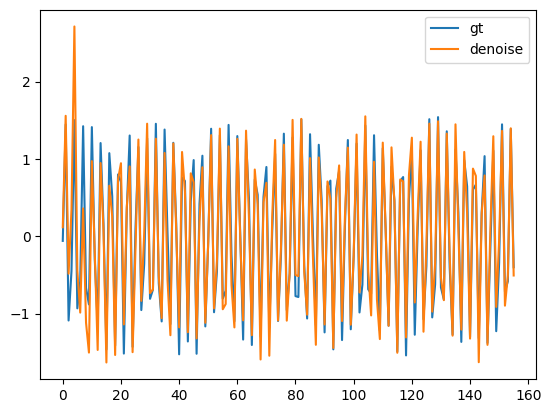

In [ ]:
plt.plot(test_gt[50], label = 'gt')
plt.plot(outputs_test_n[50], label = 'denoise')
plt.legend()

In [ ]:
print(test_mean_d)
print(test_percentile_d)

0.4848990046452751
(0.21786668008617682, 0.6988955273920652)


In [ ]:
import scipy
scipy.stats.wilcoxon(x=test_r_squared_list_deepcor, y=test_r_squared_list,alternative='greater')

WilcoxonResult(statistic=2697003.0, pvalue=0.0)